# Customer Cancellation Intervention
For a subscription-based business, reducing customer churn is critical to maintaining high growth. This project will examine a nearly six month slice of subscription transactions from such a business in an attempt to identify patterns leading to cancellation. The goal is to train a classifier capable of identifying customers at risk of cancellation using details of upcoming subscription transactions.

**A note on vocabulary:** A customer of this business purchases a **kit** containing several different products. Each of these products are then **refilled** before expiration as part of the subscription service.

## Features
1. `RefillNumber`: The ordinality of this transaction in the refill history. For example, `RefillNumber=1` corresponds to a kit's first refill, and the fifth refill will have a `RefillNumber` of `5`.
* `RefillAmount`: The cost of this refill.
* `AdvancedNotified`: Customers with up-to-date contact information are sent an email 2-4 weeks before their refill is scheduled for delivery. This field indicates which refills were preceded by such a notification.
* `KitType`: A kit's type determines the mix of products contained within it.
* `KitPurchasePrice`: The purchase price of the kit.
* `KitPurchaseSalesPerson`: The distribution channel through which the customer purchased the kit. One of `DIRECT`, `DEALER`, or `WEB`.
* `CustomerIsCorporate`: Some customers are associate with each other through a larger organization known as a corporation.
* `PreviousRefillsAmount`: The sum of the cost of all previous refills for this kit.
* `DaysSinceLastRefill`: The number of days since the last refill.
* `DaysSinceKitPurchase`: The number of days since the kit was purchased.

## Problem Discussion
The target column, `ServiceLevelChange`, can be one of `No change`, `Downgraded`, or `Deactivated` and represents the service level change of the kit in the 45 days following the refill. As such, this is a multiclass classification problem. Moreover, as will be explored below, the classes are heavily unbalanced with nearly 98% of the samples belonging to the `No change` class. The choice of performance metric will therefore be critical, as many common metrics perform poorly with unbalanced classes. Finally, due to data integrity issues, purchase information is not available for many kits and will need to be imputed.

### Performance Metric
It is much more important that the classifier correctly identify the `Downgraded` and `Deactivated` samples than the `No change` samples, as the former two "at-risk" classes require intervention while the latter does not. On the other hand, while hardly desired, it is not such a big failing if the classifier over-assigns samples to these at-risk classes, within rease. As such, the performance metric must prioritize true positives of the at-risk clases. Therefore, the classifier will be judged using two performance metrics: recall and precision, both using the `micro` averaging scheme and ignoring the `No change` class. The recall score exactly fits the problem description above, while precision reflects samples falsely assigned to the at-risk classes. Recall will be the primary metric.

*See the "Next Steps" section of the Conclusion for a potential performance metric based on lifetime customer value.*

In [1]:
# Import refill data
import numpy as np
import pandas as pd
from IPython.display import display
refill_data = pd.read_csv('refill_data.csv')
category_columns = ['AdvancedNotified', 'KitType', 'KitPurchaseSalesPerson', 'CustomerIsCorporate', 'ServiceLevelChange']
for column in category_columns:
    refill_data[column] = refill_data[column].astype('object')
display(refill_data.head(3))
display(refill_data.describe())
display(refill_data[category_columns].describe())

,RefillNumber,RefillAmount,AdvancedNotified,KitType,KitPurchasePrice,KitPurchaseSalesPerson,CustomerIsCorporate,PreviousRefillsAmount,DaysSinceLastRefill,DaysSinceKitPurchase,ServiceLevelChange
0,18,255.5,1,G,NaN,NaN,0,3789.89,250,3217,No change
1,23,323.4,1,K,NaN,NaN,0,5302.89,94,3163,No change
2,18,336.8,0,G,NaN,NaN,0,3477.80,188,3121,No change


,RefillNumber,RefillAmount,KitPurchasePrice,PreviousRefillsAmount,DaysSinceLastRefill,DaysSinceKitPurchase
count,47755.000000,47755.000000,35350.000000,47755.000000,44667.000000,47755.000000
mean,8.749702,223.675246,376.732818,1684.394852,120.098731,1914.410931
std,5.658008,164.792918,315.807762,1131.699327,106.832913,1807.472788
min,1.000000,29.450000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,75.500000,120.800000,703.440000,63.000000,943.000000
50%,8.000000,141.700000,333.350000,1686.750000,99.000000,1412.000000
75%,12.000000,322.610000,533.490000,2351.930000,154.000000,1947.000000
max,31.000000,1194.060000,3144.950000,7272.910000,2872.000000,42464.000000


,AdvancedNotified,KitType,KitPurchaseSalesPerson,CustomerIsCorporate,ServiceLevelChange
count,47755,47755,35350,47755,47755
unique,2,20,3,2,3
top,0,J,DIRECT,0,No change
freq,25721,22336,27674,41365,46677


In [2]:
# Separate data into features (X) and target (y)
X_raw = refill_data[list(refill_data.columns[:-1])]
y_all = refill_data[refill_data.columns[-1]]
print X_raw.shape
print y_all.shape

(47755, 10)
(47755,)


In [3]:
# Investigate problem severity
from IPython.display import display
print "Total refills: {}".format(y_all.count())
print "Service level changes within 45 days of refill:"
display(100*y_all.value_counts()/y_all.count())

Total refills: 47755
Service level changes within 45 days of refill:


No change      97.742645
Downgraded      1.972568
Deactivated     0.284787
Name: ServiceLevelChange, dtype: float64

Installed disable_autoscroll.py. To use it, type:
  %load_ext disable_autoscroll
The disable_autoscroll extension is already loaded. To reload it, use:
  %reload_ext disable_autoscroll


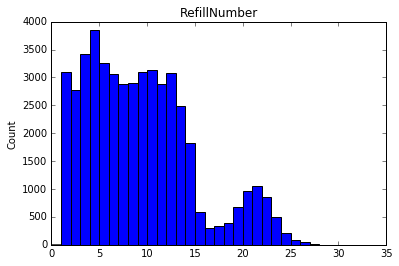

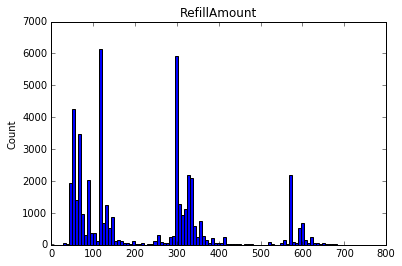

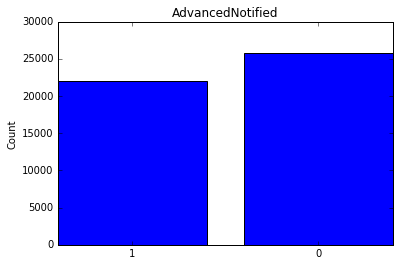

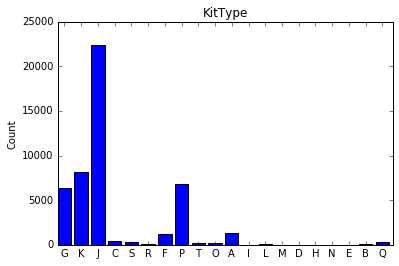

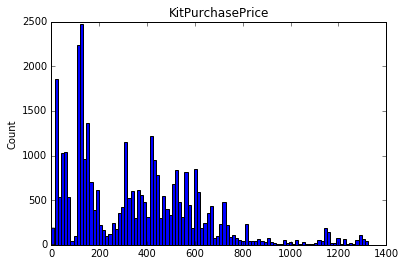

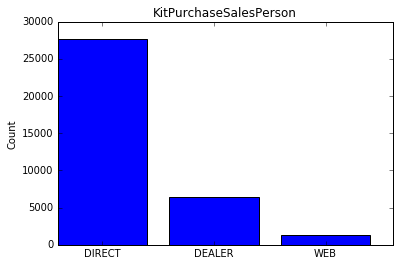

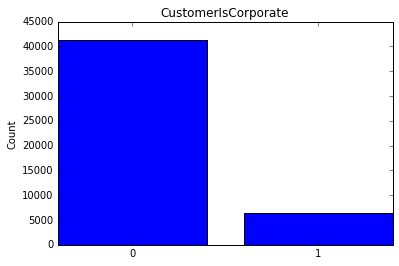

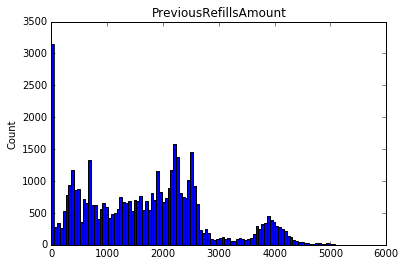

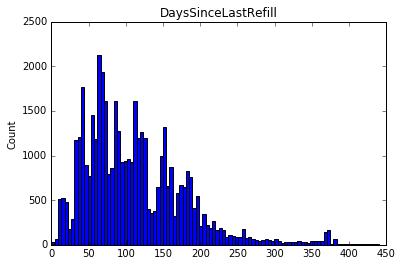

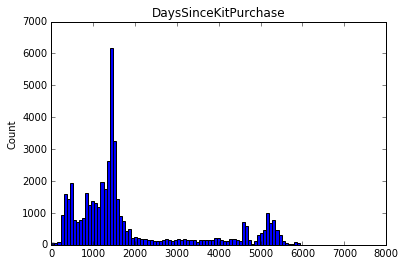

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
%install_ext https://raw.githubusercontent.com/minrk/ipython_extensions/master/extensions/disable_autoscroll.py
%load_ext disable_autoscroll
for col, col_data in X_raw.iteritems():
    if col in category_columns:
        values = [x for x in col_data.unique() if x == x]
        index = np.arange(len(values))
        counts = list(col_data[col_data == value].count() for value in values)
        bar_width = 0.8
        
        plt.bar(index, counts, bar_width)
        plt.xticks(index + bar_width/2, values)
    else:
        bins = range(col_data.max() + 1) if len(col_data.unique()) < 100 else 100
        plot_data = [x for x in col_data.values if not np.isnan(x)]
        plt.hist(plot_data, bins=bins, range=[0, min(col_data.max(), col_data.mean() + 3*col_data.std())])
    plt.title(col)
    plt.ylabel("Count")
    plt.show()

## Data Discussion (TODO)
* 3000 on first refill
* Lifetime fairly evenly distributed, drops drastically after 12th refill
  - Related: Previous refills amount fairly even, drops after ~\$2,500
  - Reflects fairly consistent average refill price
* Refill amount heavily grouped around \$100, \$300, and \$550
* Around half notified
* Almost half belong to single kit type (J)
* Kit types G, K, J, and P make up almost all the samples
* More than half sold direct
* Only 1/9th are corporate
* Days since last refill has nice distribution centered around 60-75, trails right
* Days since kit purchase has heavy spike around 1,300

In [5]:
# Preprocess features
from sklearn.preprocessing import Imputer

# Split categorical features into multiple binary columns
X_encoded = pd.DataFrame(index=X_raw.index)

for col, col_data in X_raw.iteritems():
    if col_data.dtype == object:
        col_data = pd.get_dummies(col_data, prefix=col)
    X_encoded = X_encoded.join(col_data)
    
# TODO
# Split by class to impute values
# Impute numerical with mean, categorical with mode
# Transform DaysSinceLastRefill to reciprocal, fill NULL with 0
X_all = pd.DataFrame(Imputer().fit_transform(X_encoded), index=X_encoded.index, columns=X_encoded.columns)
X_all.head()

,RefillNumber,RefillAmount,AdvancedNotified_0,AdvancedNotified_1,KitType_A,KitType_B,KitType_C,KitType_D,KitType_E,KitType_F,...,KitType_T,KitPurchasePrice,KitPurchaseSalesPerson_DEALER,KitPurchaseSalesPerson_DIRECT,KitPurchaseSalesPerson_WEB,CustomerIsCorporate_0,CustomerIsCorporate_1,PreviousRefillsAmount,DaysSinceLastRefill,DaysSinceKitPurchase
0,18,255.50,0,1,0,0,0,0,0,0,...,0,376.732818,0,0,0,1,0,3789.89,250,3217
1,23,323.40,0,1,0,0,0,0,0,0,...,0,376.732818,0,0,0,1,0,5302.89,94,3163
2,18,336.80,1,0,0,0,0,0,0,0,...,0,376.732818,0,0,0,1,0,3477.80,188,3121
3,19,75.33,0,1,0,0,0,0,0,0,...,0,376.732818,0,0,0,1,0,3814.60,71,3192
4,4,49.45,1,0,0,0,0,0,0,0,...,0,376.732818,0,0,0,0,1,819.58,123,3154


In [32]:
# Encode target labels
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_all = le.fit_transform(y_raw)
# class_names = le.classes_
# print class_names
# print le.transform(class_names)

In [6]:
# Train classifier
from sklearn.metrics import recall_score, precision_score, make_scorer
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

recall_scorer = make_scorer(recall_score, labels=['Deactivated', 'Downgraded'], average='micro')
precision_scorer = make_scorer(precision_score, labels=['Deactivated', 'Downgraded'], average='micro')
    
results = []
classifiers = [
    LinearSVC(dual=False),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    AdaBoostClassifier(),
    RandomForestClassifier()
]
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all)
for clf in classifiers:
    classifier = clf.__class__.__name__
    recall = cross_val_score(clf, X_train, y_train, scoring=recall_scorer)
    precision = cross_val_score(clf, X_train, y_train, scoring=precision_scorer)
    results.append([classifier, recall.mean(), precision.mean()])
    
results = pd.DataFrame(
    data = results,
    columns = [
        'classifier',
        'recall',
        'precision'
    ]
)

display(results)

/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,classifier,recall,precision
0,LinearSVC,0.000000,0.000000
1,DecisionTreeClassifier,0.066057,0.061296
2,KNeighborsClassifier,0.002323,0.114286
3,AdaBoostClassifier,0.000000,0.000000
4,RandomForestClassifier,0.034747,0.126962
